# Extracting Tweets and Sentiment Analysis

This code can and should be customized with your custom file path and search query.

The first step is to import all of the relevant packages:

In [34]:
import os
import pandas as pd
import tweepy
import re
import csv
import string
from textblob import TextBlob
import preprocessor as p
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
import keys


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maggiekahn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maggiekahn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The pink warning box above is just to let you know that those packages are up-to-date.  You may need to install them if your version of Anaconda did not come with those packages installed. 

Step 2 is below. 

In [35]:
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(keys.consumer_key, keys.consumer_secret)
auth.set_access_token(keys.access_token, keys.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)
 

Next, we want to create a .csv file to store the tweets and the sentiment and subjectivity data. 

If you have a Mac use this format:
covid_tweets= '/Users/jocamach/Dropbox/ALI/USD TEACHING/ECON 385 BUSN ANALYTICS STRATEGY/FALL 2020/PYTHON CODE FILES/snippets_ipynb/covid_tweets.csv'

If you have a PC use this format:
covid_tweets = "C:\\Users\\Sanchez\\Dropbox\\ALI\\USD TEACHING\\ECON 385 BUSN ANALYTICS STRATEGY\\FALL 2020\\PYTHON CODE FILES\\snippets_ipynb\\covid_tweets.csv"


In [230]:
nike_tweets='/Users/maggiekahn/Desktop/BAS/nike_tweets.csv' 

Below is where we append the .csv file to store the Tweet data mined from Twitter.  When the code is finished running, you will find the CSV file in your working directory.

In [234]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'user', 'followers',
        'friends' ,'hashtags', 'place', 'coordinates','favorites']
 
#set two date variables for date range
start_date = '2020-09-01'
end_date = '2020-09-20'
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
 
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)
 
 
#mrhod clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
 
    #after tweepy preprocessing the keft colon remains after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚:', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
 
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)
 
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english; if not, skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when running the code, the code below replaces the retweet amount and
            #number of favorites that have changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
 
 
           #tweepy preprocessing called for basic preprocessing
            clean_text = p.clean(status['text'])
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count'], status['user'], status['user']['followers_count'],
                          status['user']['friends_count']]
 
            #to append original author of the tweet
            #new_entry.append(status['user'])
 
           # try:
           #     is_sensitive = status['possibly_sensitive']
           # except KeyError:
           #     is_sensitive = None
           # new_entry.append(is_sensitive)
 
            # hashtags and mentions are saved using comma separted format
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")
 
#declare keywords as a query for three categories
nike_keywords = '#nike'

#call main method passing keywords and file path
write_tweets(nike_keywords,  nike_tweets)


In [237]:
adidas_tweets='/Users/maggiekahn/Desktop/BAS/adidas_tweets.csv'

In [238]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'user', 'followers',
        'friends' ,'hashtags', 'place', 'coordinates','favorites']
 
#set two date variables for date range
start_date = '2020-09-01'
end_date = '2020-09-20'
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
 
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)
 
 
#mrhod clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
 
    #after tweepy preprocessing the keft colon remains after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚:', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
 
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)
 
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english; if not, skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when running the code, the code below replaces the retweet amount and
            #number of favorites that have changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
 
 
           #tweepy preprocessing called for basic preprocessing
            clean_text = p.clean(status['text'])
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count'], status['user'], status['user']['followers_count'],
                          status['user']['friends_count']]
 
            #to append original author of the tweet
            #new_entry.append(status['user'])
 
           # try:
           #     is_sensitive = status['possibly_sensitive']
           # except KeyError:
           #     is_sensitive = None
           # new_entry.append(is_sensitive)
 
            # hashtags and mentions are saved using comma separted format
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")
 
#declare keywords as a query for three categories
adidas_keywords = '#adidas'

#call main method passing keywords and file path
write_tweets(adidas_keywords,  adidas_tweets)


Importing relevant packages 

In [341]:
#begin by importing all of the relevant packages we will need
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
import keys


from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#read in the data 
NikeData=pd.read_csv('nike_tweets.csv')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maggiekahn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maggiekahn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking at the top of the table for Nike 

In [240]:
NikeData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443455840485318662,Thu Sep 30 06:01:05 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...","Introducing the Nike Daybreak, your next guilt...",Introducing Nike Daybreak next guilty pleasure...,"Sentiment(polarity=-0.25, subjectivity=0.5)",-0.25,0.5,en,...,82,473,nike,NaN,NaN,NaN,0.0,555.0,0.000000,0.000000
1,1,1443410272094326787,Thu Sep 30 03:00:00 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out Nike Air Max Oketo Toddler Black Pin...,Check Nike Air Max Oketo Toddler Black Pink St...,"Sentiment(polarity=-0.13333333333333333, subje...",-0.1333333333333333,0.3666666666666667,en,...,302,68,Nike,NaN,"Hanover, MA",NaN,0.0,370.0,0.000000,0.000000
2,2,1443313087394684930,Wed Sep 29 20:33:50 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",My affirmation: I am capable. I am confident. ...,My affirmation I capable I confident I CAN I J...,"Sentiment(polarity=0.35, subjectivity=0.616666...",0.35,0.6166666666666667,en,...,25342,7989,NaN,NaN,Live in LA ★ Raised in KC,NaN,6.0,33331.0,0.000180,0.018001
3,3,1443230220262256647,Wed Sep 29 15:04:33 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...",Win a chance to buy Air Jordan Retro 13 by fil...,Win chance buy Air Jordan Retro fill raffle fo...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.8,0.4,en,...,276,200,airjordan,NaN,"Chicago, IL",NaN,0.0,476.0,0.000000,0.000000
4,4,1443171555559686145,Wed Sep 29 11:11:26 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @NikePHStore: Jordan One Take II PF\nOrder ...,Jordan One Take II PFOrder Here OFF Now Only p...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,en,...,17,22,"Nike, NikePH, Jordan1",NikePHStore,"Cavite, Philippines",NaN,2.0,39.0,0.051282,5.128205


Looking at the bottom of the table for Nike 

In [241]:
NikeData.tail()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
3561,1442783357801091076,Tue Sep 28 09:28:52 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,0,...,7,"poshmark, fashion, style, shopmycloset",Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3562,1442783337127419906,Tue Sep 28 09:28:47 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,0,...,0,"poshmark, fashion, style, shopmycloset",Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3563,1442783321310654473,Tue Sep 28 09:28:44 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,0,...,9,"poshmark, fashion, style, shopmycloset",Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3564,1442782764839866371,Tue Sep 28 09:26:31 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","The latest comment on my blog, requiring appro...",The latest comment blog requiring approval see...,"Sentiment(polarity=0.25, subjectivity=0.45)",0.25,0.45,en,2,...,1001,"Nike, NFL",NaN,London,NaN,NaN,NaN,NaN,NaN,NaN
3565,1442782387079888896,Tue Sep 28 09:25:01 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @wassystyle1: Love these 🙏🏽 #snkrskickcheck...,Love,"Sentiment(polarity=0.5, subjectivity=0.6)",0.5,0.6,en,0,...,299,"snkrskickcheck, YourSneakersAreDope, MondayMot...","wassystyle1, nikestore",Universe,NaN,NaN,NaN,NaN,NaN,NaN


Looking at some Statistics for the Nike Data for polarity and subjectivity 

In [242]:
#descriptive statistics 
sumstats=NikeData.describe()
#the pandas round function rounds to one decimal place. You can specifiy the number of decimal places inside the pararentheses
sumstats.round()

,impressions,reach,engagement,engagement_rate
count,49.0,49.0,49.0,49.0
mean,1.0,2554.0,0.0,36.0
std,1.0,6844.0,1.0,97.0
min,0.0,1.0,0.0,0.0
25%,1.0,39.0,0.0,0.0
50%,1.0,125.0,0.0,1.0
75%,2.0,671.0,0.0,5.0
max,6.0,33331.0,5.0,500.0


In [257]:
#calculate impressions
impressions = NikeData["favorite_count"] + NikeData["retweet_count"]
NikeData["impressions"] = impressions #creating new column 

In [258]:
NikeData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443455840485318662,Thu Sep 30 06:01:05 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...","Introducing the Nike Daybreak, your next guilt...",Introducing Nike Daybreak next guilty pleasure...,"Sentiment(polarity=-0.25, subjectivity=0.5)",-0.25,0.5,en,...,82,473,nike,NaN,NaN,NaN,00,82473,0.000000,0.000000
1,1,1443410272094326787,Thu Sep 30 03:00:00 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out Nike Air Max Oketo Toddler Black Pin...,Check Nike Air Max Oketo Toddler Black Pink St...,"Sentiment(polarity=-0.13333333333333333, subje...",-0.1333333333333333,0.3666666666666667,en,...,302,68,Nike,NaN,"Hanover, MA",NaN,00,30268,0.000000,0.000000
2,2,1443313087394684930,Wed Sep 29 20:33:50 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",My affirmation: I am capable. I am confident. ...,My affirmation I capable I confident I CAN I J...,"Sentiment(polarity=0.35, subjectivity=0.616666...",0.35,0.6166666666666667,en,...,25342,7989,NaN,NaN,Live in LA ★ Raised in KC,NaN,60,253427989,0.000180,0.018001
3,3,1443230220262256647,Wed Sep 29 15:04:33 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...",Win a chance to buy Air Jordan Retro 13 by fil...,Win chance buy Air Jordan Retro fill raffle fo...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.8,0.4,en,...,276,200,airjordan,NaN,"Chicago, IL",NaN,00,276200,0.000000,0.000000
4,4,1443171555559686145,Wed Sep 29 11:11:26 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @NikePHStore: Jordan One Take II PF\nOrder ...,Jordan One Take II PFOrder Here OFF Now Only p...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,en,...,17,22,"Nike, NikePH, Jordan1",NikePHStore,"Cavite, Philippines",NaN,02,1722,0.051282,5.128205


Calculating Reach 

In [259]:
#calculate reach
reach = NikeData["followers"] + NikeData["friends"] #reach what you are saving the column as 
NikeData["reach"] = reach #Create new column for followers and friends 

In [260]:
NikeData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443455840485318662,Thu Sep 30 06:01:05 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...","Introducing the Nike Daybreak, your next guilt...",Introducing Nike Daybreak next guilty pleasure...,"Sentiment(polarity=-0.25, subjectivity=0.5)",-0.25,0.5,en,...,82,473,nike,NaN,NaN,NaN,00,82473,0.000000,0.000000
1,1,1443410272094326787,Thu Sep 30 03:00:00 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out Nike Air Max Oketo Toddler Black Pin...,Check Nike Air Max Oketo Toddler Black Pink St...,"Sentiment(polarity=-0.13333333333333333, subje...",-0.1333333333333333,0.3666666666666667,en,...,302,68,Nike,NaN,"Hanover, MA",NaN,00,30268,0.000000,0.000000
2,2,1443313087394684930,Wed Sep 29 20:33:50 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",My affirmation: I am capable. I am confident. ...,My affirmation I capable I confident I CAN I J...,"Sentiment(polarity=0.35, subjectivity=0.616666...",0.35,0.6166666666666667,en,...,25342,7989,NaN,NaN,Live in LA ★ Raised in KC,NaN,60,253427989,0.000180,0.018001
3,3,1443230220262256647,Wed Sep 29 15:04:33 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...",Win a chance to buy Air Jordan Retro 13 by fil...,Win chance buy Air Jordan Retro fill raffle fo...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.8,0.4,en,...,276,200,airjordan,NaN,"Chicago, IL",NaN,00,276200,0.000000,0.000000
4,4,1443171555559686145,Wed Sep 29 11:11:26 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @NikePHStore: Jordan One Take II PF\nOrder ...,Jordan One Take II PFOrder Here OFF Now Only p...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,en,...,17,22,"Nike, NikePH, Jordan1",NikePHStore,"Cavite, Philippines",NaN,02,1722,0.051282,5.128205


Looking at the engagement of the users 

In [263]:
NikeData.dtypes

Unnamed: 0          object
id                  object
created_at          object
source              object
original_text       object
clean_text          object
sentiment           object
polarity            object
subjectivity        object
lang                object
favorite_count      object
retweet_count       object
user                object
followers           object
friends             object
hashtags            object
place               object
coordinates         object
favorites           object
impressions         object
reach               object
engagement         float64
engagement_rate    float64
dtype: object

In [275]:
NikeData['impressions']= pd.to_numeric(NikeData["impressions"], errors="coerce")

In [276]:
NikeData['reach']= pd.to_numeric(NikeData["reach"], errors="coerce")

In [277]:
NikeData['friends']= pd.to_numeric(NikeData["friends"], errors="coerce")

In [278]:
NikeData['followers']= pd.to_numeric(NikeData["followers"], errors="coerce")

In [279]:
#calculate engagement metric
engagement = NikeData["impressions"] / NikeData["reach"]
NikeData["engagement"] = engagement #new column called engagement with the new information you just added 

Looking at the top of the table for Nike 

In [280]:
NikeData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443455840485318662,Thu Sep 30 06:01:05 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...","Introducing the Nike Daybreak, your next guilt...",Introducing Nike Daybreak next guilty pleasure...,"Sentiment(polarity=-0.25, subjectivity=0.5)",-0.25,0.5,en,...,82.0,473.0,nike,NaN,NaN,NaN,0.0,82473.0,0.000000e+00,0.000000
1,1,1443410272094326787,Thu Sep 30 03:00:00 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out Nike Air Max Oketo Toddler Black Pin...,Check Nike Air Max Oketo Toddler Black Pink St...,"Sentiment(polarity=-0.13333333333333333, subje...",-0.1333333333333333,0.3666666666666667,en,...,302.0,68.0,Nike,NaN,"Hanover, MA",NaN,0.0,30268.0,0.000000e+00,0.000000
2,2,1443313087394684930,Wed Sep 29 20:33:50 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",My affirmation: I am capable. I am confident. ...,My affirmation I capable I confident I CAN I J...,"Sentiment(polarity=0.35, subjectivity=0.616666...",0.35,0.6166666666666667,en,...,25342.0,7989.0,NaN,NaN,Live in LA ★ Raised in KC,NaN,60.0,253427989.0,2.367536e-07,0.018001
3,3,1443230220262256647,Wed Sep 29 15:04:33 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...",Win a chance to buy Air Jordan Retro 13 by fil...,Win chance buy Air Jordan Retro fill raffle fo...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.8,0.4,en,...,276.0,200.0,airjordan,NaN,"Chicago, IL",NaN,0.0,276200.0,0.000000e+00,0.000000
4,4,1443171555559686145,Wed Sep 29 11:11:26 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @NikePHStore: Jordan One Take II PF\nOrder ...,Jordan One Take II PFOrder Here OFF Now Only p...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,en,...,17.0,22.0,"Nike, NikePH, Jordan1",NikePHStore,"Cavite, Philippines",NaN,2.0,1722.0,1.161440e-03,5.128205


Looking at the tail end of the code 

In [281]:
NikeData.tail()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
3561,1442783357801091076,Tue Sep 28 09:28:52 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,0,...,7.0,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3562,1442783337127419906,Tue Sep 28 09:28:47 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,0,...,0.0,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3563,1442783321310654473,Tue Sep 28 09:28:44 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,0,...,9.0,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3564,1442782764839866371,Tue Sep 28 09:26:31 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","The latest comment on my blog, requiring appro...",The latest comment blog requiring approval see...,"Sentiment(polarity=0.25, subjectivity=0.45)",0.25,0.45,en,2,...,1001.0,NaN,NaN,London,NaN,NaN,NaN,NaN,NaN,NaN
3565,1442782387079888896,Tue Sep 28 09:25:01 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @wassystyle1: Love these 🙏🏽 #snkrskickcheck...,Love,"Sentiment(polarity=0.5, subjectivity=0.6)",0.5,0.6,en,0,...,299.0,NaN,"wassystyle1, nikestore",Universe,NaN,NaN,NaN,NaN,NaN,NaN


In [282]:
#descriptive statistics 
sumstats=AdidasData.describe()
#the pandas round function rounds to one decimal place. You can specifiy the number of decimal places inside the pararentheses
sumstats.round()

,id,polarity,subjectivity,favorite_count,retweet_count,followers,friends,favorites,impressions,reach,engagement,engagement_rate
count,3.600000e+01,36.0,36.0,36.0,36.0,36.0,36.0,0.0,36.0,36.0,36.0,36.0
mean,1.442167e+18,0.0,0.0,5.0,2.0,4097.0,471.0,NaN,6.0,4568.0,0.0,0.0
std,8.286251e+14,0.0,0.0,7.0,2.0,4074.0,1123.0,NaN,7.0,3997.0,0.0,1.0
min,1.440258e+18,-0.0,0.0,0.0,0.0,1.0,1.0,NaN,0.0,2.0,0.0,0.0
25%,1.442070e+18,0.0,0.0,0.0,0.0,229.0,76.0,NaN,1.0,484.0,0.0,0.0
50%,1.442182e+18,0.0,0.0,0.0,1.0,1618.0,76.0,NaN,5.0,4355.0,0.0,0.0
75%,1.442722e+18,0.0,0.0,7.0,3.0,8537.0,366.0,NaN,8.0,8613.0,0.0,0.0
max,1.443607e+18,0.0,1.0,29.0,9.0,8537.0,4987.0,NaN,33.0,8613.0,0.0,3.0


In [283]:
#descriptive statistics 
sumstats_engagement=NikeData.describe()
#the pandas round function rounds to one decimal place. You can specifiy the number of decimal places inside the pararentheses
sumstats_engagement.round()

,followers,friends,impressions,reach,engagement,engagement_rate
count,2990.0,49.0,2.530000e+02,4.900000e+01,49.0,49.0
mean,1205.0,872.0,3.455121e+07,4.451692e+07,0.0,36.0
std,2999.0,2411.0,2.131722e+08,2.432961e+08,1.0,97.0
min,0.0,0.0,0.000000e+00,7.000000e+00,0.0,0.0
25%,47.0,22.0,1.000000e+01,1.722000e+03,0.0,0.0
50%,280.0,51.0,1.722000e+03,1.259200e+04,0.0,1.0
75%,1089.0,363.0,1.644400e+05,2.034280e+05,0.0,5.0
max,78586.0,12173.0,1.691012e+09,1.691012e+09,3.0,500.0


In [52]:
NikeData.tail()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,...,user,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement
44,1440798272063361027,Wed Sep 22 22:00:51 +0000 2021,"<a href=""https://www.hootsuite.com"" rel=""nofol...",Simplicity is all we need sometimes 👟\n\nShop ...,Simplicity need sometimes Shop Sneakers ....,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,...,"{'id': 48015916, 'id_str': '48015916', 'name':...",10149,363,"nike, nikeshoes",NaN,Canada,NaN,0,10512,0.000000
45,1440727105914900482,Wed Sep 22 17:18:04 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",This offer sponsored By Nike \nWho Need $100 N...,This offer sponsored By Nike Who Need 100 Nike...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,1,...,"{'id': 1430971556902014979, 'id_str': '1430971...",9,106,NaN,NaN,NaN,NaN,1,115,0.008696
46,1440659939848900627,Wed Sep 22 12:51:10 +0000 2021,"<a href=""http://www.justgoscha.com"" rel=""nofol...",RT @anikjaindesign: Concept animation for @nik...,Concept animation,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,...,"{'id': 2785259025, 'id_str': '2785259025', 'na...",16910,12173,"sanitizer, sanitizeyourhands, covidvacccine, c...","anikjaindesign, Nike",Berlin,NaN,1,29083,0.000034
47,1440659589167337477,Wed Sep 22 12:49:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Concept animation for @nike \n#sanitizer #sani...,Concept animation,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,2,...,"{'id': 1350155597031694336, 'id_str': '1350155...",47,63,"sanitizer, sanitizeyourhands, covidvacccine, c...",Nike,NaN,NaN,3,110,0.027273
48,1440433167714840585,Tue Sep 21 21:50:03 +0000 2021,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",PRE LIVES. #fitness #running #run #goals #uk #...,PRE LIVES,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,1,...,"{'id': 37180455, 'id_str': '37180455', 'name':...",203,428,"fitness, running, run, goals, uk, leeds, nike,...",NaN,Leeds,NaN,1,631,0.001585


Printing the engagement rate in a percentage

In [284]:
#calculate engagement rate as a percentage
engagement_rate = NikeData["engagement"]*100 #100 is the scaler number (multiplication by scaler)
NikeData["engagement_rate"] = engagement_rate

In [285]:
NikeData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443455840485318662,Thu Sep 30 06:01:05 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...","Introducing the Nike Daybreak, your next guilt...",Introducing Nike Daybreak next guilty pleasure...,"Sentiment(polarity=-0.25, subjectivity=0.5)",-0.25,0.5,en,...,82.0,473.0,nike,NaN,NaN,NaN,0.0,82473.0,0.000000e+00,0.000000
1,1,1443410272094326787,Thu Sep 30 03:00:00 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out Nike Air Max Oketo Toddler Black Pin...,Check Nike Air Max Oketo Toddler Black Pink St...,"Sentiment(polarity=-0.13333333333333333, subje...",-0.1333333333333333,0.3666666666666667,en,...,302.0,68.0,Nike,NaN,"Hanover, MA",NaN,0.0,30268.0,0.000000e+00,0.000000
2,2,1443313087394684930,Wed Sep 29 20:33:50 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",My affirmation: I am capable. I am confident. ...,My affirmation I capable I confident I CAN I J...,"Sentiment(polarity=0.35, subjectivity=0.616666...",0.35,0.6166666666666667,en,...,25342.0,7989.0,NaN,NaN,Live in LA ★ Raised in KC,NaN,60.0,253427989.0,2.367536e-07,0.000024
3,3,1443230220262256647,Wed Sep 29 15:04:33 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...",Win a chance to buy Air Jordan Retro 13 by fil...,Win chance buy Air Jordan Retro fill raffle fo...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.8,0.4,en,...,276.0,200.0,airjordan,NaN,"Chicago, IL",NaN,0.0,276200.0,0.000000e+00,0.000000
4,4,1443171555559686145,Wed Sep 29 11:11:26 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @NikePHStore: Jordan One Take II PF\nOrder ...,Jordan One Take II PFOrder Here OFF Now Only p...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,en,...,17.0,22.0,"Nike, NikePH, Jordan1",NikePHStore,"Cavite, Philippines",NaN,2.0,1722.0,1.161440e-03,0.116144


Repeating the same process as above but with my Adidas information 

In [286]:
#read in the data 
AdidasData=pd.read_csv('adidas_tweets.csv')


Looking at the top of the table for Adidas

In [287]:
AdidasData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,8537,76,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,7.0,8613.0,0.000813,0.081272
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,en,...,8537,76,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,4.0,8613.0,0.000464,0.046441
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,225,233,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1.0,458.0,0.002183,0.218341
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,8537,76,"adidas, cpcompany",LukeShaw23,England,NaN,13.0,8613.0,0.001509,0.150935
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,en,...,377,543,NaN,NaN,"Delaware, USA",NaN,0.0,920.0,0.000000,0.000000


Looking at the tail end of the Adidas data

In [289]:
AdidasData.tail()


,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
10081,1442647656388431873,Tue Sep 28 00:29:39 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,0,...,52,"poshmark, fashion","Poshmarkapp, CarolSweazy",Southern California,NaN,NaN,NaN,NaN,NaN,NaN
10082,1442646918727880708,Tue Sep 28 00:26:43 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @1234KITS: #LeedsUnited #PremierLeague #Eng...,/2022,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,...,355,"LeedsUnited, PremierLeague, England, adidas, T...",1234KITS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10083,1442645031312150529,Tue Sep 28 00:19:13 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",🚨NEW EVENT RELEASE🚨\n\nRISE Softball is excite...,NEW EVENT RELEASERISE Softball excited announc...,"Sentiment(polarity=0.2556818181818182, subject...",0.2556818181818182,0.6022727272727273,en,0,...,4580,NaN,NaN,NaN,"[[-90.4181075, 41.696088], [-82.122971, 41.696...",NaN,NaN,NaN,NaN,NaN
10084,1442644103301410819,Tue Sep 28 00:15:31 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out NWT ADIDAS CLIMAHEAT GILET TRAINING ...,Check NWT ADIDAS CLIMAHEAT GILET TRAINING VEST...,"Sentiment(polarity=-0.16666666666666666, subje...",-0.16666666666666666,0.43333333333333335,en,0,...,2687,"adidas, ActivewearVest",eBay,South Florida,NaN,NaN,NaN,NaN,NaN,NaN
10085,1442643020243943426,Tue Sep 28 00:11:13 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @FerRSayajin: Sketch of one of Fortnite's m...,Sketch one Fortnite 's popular skins Ruby,"Sentiment(polarity=0.6, subjectivity=0.9)",0.6,0.9,en,0,...,1192,"mangaka, illustrations, illustrationart, Fortn...",FerRSayajin,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at some descriptive stats for Adidas

In [290]:
#descriptive statistics 
sumstats=AdidasData.describe()
#the pandas round function rounds to one decimal place. You can specifiy the number of decimal places inside the pararentheses
sumstats.round()

,favorites,impressions,reach,engagement,engagement_rate
count,0.0,36.0,36.0,36.0,36.0
mean,NaN,6.0,4568.0,0.0,0.0
std,NaN,7.0,3997.0,0.0,1.0
min,NaN,0.0,2.0,0.0,0.0
25%,NaN,1.0,484.0,0.0,0.0
50%,NaN,5.0,4355.0,0.0,0.0
75%,NaN,8.0,8613.0,0.0,0.0
max,NaN,33.0,8613.0,0.0,3.0


Impressions for Adidas data

In [291]:
#calculate impressions
impressions = AdidasData["favorite_count"] + AdidasData["retweet_count"]
AdidasData["impressions"] = impressions #creating new column 

In [292]:
AdidasData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,8537,76,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,70,8613.0,0.000813,0.081272
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,en,...,8537,76,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,40,8613.0,0.000464,0.046441
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,225,233,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,01,458.0,0.002183,0.218341
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,8537,76,"adidas, cpcompany",LukeShaw23,England,NaN,121,8613.0,0.001509,0.150935
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,en,...,377,543,NaN,NaN,"Delaware, USA",NaN,00,920.0,0.000000,0.000000


Calculating the reach followers have 

In [293]:
#calculate reach
reach = AdidasData["followers"] + AdidasData["friends"] #reach what you are saving the column as 
AdidasData["reach"] = reach #Create new column for followers and friends 

In [294]:
AdidasData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,8537,76,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,70,853776,0.000813,0.081272
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,en,...,8537,76,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,40,853776,0.000464,0.046441
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,225,233,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,01,225233,0.002183,0.218341
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,8537,76,"adidas, cpcompany",LukeShaw23,England,NaN,121,853776,0.001509,0.150935
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,en,...,377,543,NaN,NaN,"Delaware, USA",NaN,00,377543,0.000000,0.000000


Calculating Engagement with impressions and reach 

In [296]:
AdidasData['impressions']= pd.to_numeric(AdidasData["impressions"], errors="coerce")

In [297]:
AdidasData['reach']= pd.to_numeric(AdidasData["reach"], errors="coerce")


In [298]:
AdidasData['friends']= pd.to_numeric(AdidasData["friends"], errors="coerce")

In [299]:
AdidasData['followers']= pd.to_numeric(AdidasData["followers"], errors="coerce")

In [300]:
#calculate engagement metric
engagement = AdidasData["impressions"] / AdidasData["reach"]
AdidasData["engagement"] = engagement #new column called engagement with the new information you just added 

In [301]:
AdidasData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,8537.0,76.0,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,70.0,853776.0,0.000082,0.081272
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,en,...,8537.0,76.0,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,40.0,853776.0,0.000047,0.046441
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,225.0,233.0,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1.0,225233.0,0.000004,0.218341
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,8537.0,76.0,"adidas, cpcompany",LukeShaw23,England,NaN,121.0,853776.0,0.000142,0.150935
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,en,...,377.0,543.0,NaN,NaN,"Delaware, USA",NaN,0.0,377543.0,0.000000,0.000000


Descriptive statistics for the newly calculated engagement data 

In [302]:
#descriptive statistics 
sumstats_engagement=AdidasData.describe()
#the pandas round function rounds to one decimal place. You can specifiy the number of decimal places inside the pararentheses
sumstats_engagement.round()

,followers,friends,favorites,impressions,reach,engagement,engagement_rate
count,6734.0,36.0,0.0,36.0,36.0,36.0,36.0
mean,863.0,471.0,NaN,47.0,1823330.0,0.0,0.0
std,1692.0,1123.0,NaN,72.0,5949536.0,0.0,1.0
min,0.0,1.0,NaN,0.0,11.0,0.0,0.0
25%,88.0,76.0,NaN,3.0,132081.0,0.0,0.0
50%,301.0,76.0,NaN,10.0,853776.0,0.0,0.0
75%,862.0,366.0,NaN,70.0,853776.0,0.0,0.0
max,30021.0,4987.0,NaN,291.0,34534987.0,0.0,3.0


Printing the engagement rate as a percentage 

In [303]:
#calculate engagement rate as a percentage
engagement_rate = AdidasData["engagement"]*100 #100 is the scaler number (multiplication by scaler)
AdidasData["engagement_rate"] = engagement_rate

In [304]:
AdidasData.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,8537.0,76.0,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,70.0,853776.0,0.000082,0.008199
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,en,...,8537.0,76.0,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,40.0,853776.0,0.000047,0.004685
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,225.0,233.0,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1.0,225233.0,0.000004,0.000444
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,en,...,8537.0,76.0,"adidas, cpcompany",LukeShaw23,England,NaN,121.0,853776.0,0.000142,0.014172
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,en,...,377.0,543.0,NaN,NaN,"Delaware, USA",NaN,0.0,377543.0,0.000000,0.000000


Exporting the csv to an excel file Nike

In [305]:
#export your data to a csv file
NikeData.to_csv('nike_tweets.csv')

Exporting the csv to an excel file Adidas

In [306]:
#export your data to a csv file
AdidasData.to_csv('adidas_tweets.csv')

Exporting my files to excel

In [307]:
NikeData.to_excel('nike_tweets.xls') #exporting file to excel 

<ipython-input-307-6a1e2ae5a8af>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  NikeData.to_excel('nike_tweets.xls') #exporting file to excel


In [308]:
AdidasData.to_excel('adidas_tweets.xls') #exporting file to excel 

<ipython-input-308-cbfd9408448f>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  AdidasData.to_excel('adidas_tweets.xls') #exporting file to excel


Checking the top couple of rows 

In [309]:
NikevsAdidas.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,...,76,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,7,8613,0.000813,0.081272,0
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.178788,0.500000,en,...,76,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,4,8613,0.000464,0.046441,0
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375000,0.750000,en,...,233,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1,458,0.002183,0.218341,0
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375000,0.750000,en,...,76,"adidas, cpcompany",LukeShaw23,England,NaN,13,8613,0.001509,0.150935,0
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.318182,0.477273,en,...,543,NaN,NaN,"Delaware, USA",NaN,0,920,0.000000,0.000000,0


In [311]:
NikevsAdidas.tail()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
44,44,1440798272063361027,Wed Sep 22 22:00:51 +0000 2021,"<a href=""https://www.hootsuite.com"" rel=""nofol...",Simplicity is all we need sometimes 👟\n\nShop ...,Simplicity need sometimes Shop Sneakers ....,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,363,"nike, nikeshoes",NaN,Canada,NaN,0,10512,0.000000,0.000000,1
45,45,1440727105914900482,Wed Sep 22 17:18:04 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",This offer sponsored By Nike \nWho Need $100 N...,This offer sponsored By Nike Who Need 100 Nike...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,106,NaN,NaN,NaN,NaN,1,115,0.008696,0.869565,1
46,46,1440659939848900627,Wed Sep 22 12:51:10 +0000 2021,"<a href=""http://www.justgoscha.com"" rel=""nofol...",RT @anikjaindesign: Concept animation for @nik...,Concept animation,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,12173,"sanitizer, sanitizeyourhands, covidvacccine, c...","anikjaindesign, Nike",Berlin,NaN,1,29083,0.000034,0.003438,1
47,47,1440659589167337477,Wed Sep 22 12:49:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Concept animation for @nike \n#sanitizer #sani...,Concept animation,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,63,"sanitizer, sanitizeyourhands, covidvacccine, c...",Nike,NaN,NaN,3,110,0.027273,2.727273,1
48,48,1440433167714840585,Tue Sep 21 21:50:03 +0000 2021,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",PRE LIVES. #fitness #running #run #goals #uk #...,PRE LIVES,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,...,428,"fitness, running, run, goals, uk, leeds, nike,...",NaN,Leeds,NaN,1,631,0.001585,0.158479,1


Calculating Impressions for the combined data 

In [312]:
#calculate impressions
impressions = NikevsAdidas["favorite_count"] + NikevsAdidas["retweet_count"]
NikevsAdidas["impressions"] = impressions

In [81]:
NikevsAdidas.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,1443455840485318662,Thu Sep 30 06:01:05 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...","Introducing the Nike Daybreak, your next guilt...",Introducing Nike Daybreak next guilty pleasure...,"Sentiment(polarity=-0.25, subjectivity=0.5)",-0.250000,0.500000,en,...,82,473,nike,NaN,NaN,NaN,0,555,0.000000,0.000000
1,1,1443410272094326787,Thu Sep 30 03:00:00 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out Nike Air Max Oketo Toddler Black Pin...,Check Nike Air Max Oketo Toddler Black Pink St...,"Sentiment(polarity=-0.13333333333333333, subje...",-0.133333,0.366667,en,...,302,68,Nike,NaN,"Hanover, MA",NaN,0,370,0.000000,0.000000
2,2,1443313087394684930,Wed Sep 29 20:33:50 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",My affirmation: I am capable. I am confident. ...,My affirmation I capable I confident I CAN I J...,"Sentiment(polarity=0.35, subjectivity=0.616666...",0.350000,0.616667,en,...,25342,7989,NaN,NaN,Live in LA ★ Raised in KC,NaN,6,33331,0.000180,0.018001
3,3,1443230220262256647,Wed Sep 29 15:04:33 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...",Win a chance to buy Air Jordan Retro 13 by fil...,Win chance buy Air Jordan Retro fill raffle fo...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.800000,0.400000,en,...,276,200,airjordan,NaN,"Chicago, IL",NaN,0,476,0.000000,0.000000
4,4,1443171555559686145,Wed Sep 29 11:11:26 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @NikePHStore: Jordan One Take II PF\nOrder ...,Jordan One Take II PFOrder Here OFF Now Only p...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.000000,1.000000,en,...,17,22,"Nike, NikePH, Jordan1",NikePHStore,"Cavite, Philippines",NaN,2,39,0.051282,5.128205


In [313]:
#calculate engagement rate as a percentage
engagement_rate = NikevsAdidas["engagement"]*100 #100 is the scaler number (multiplication by scaler)
NikevsAdidas["engagement_rate"] = engagement_rate

In [314]:
NikevsAdidas.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,...,76,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,7,8613,0.000813,0.081272,0
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.178788,0.500000,en,...,76,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,4,8613,0.000464,0.046441,0
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375000,0.750000,en,...,233,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1,458,0.002183,0.218341,0
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375000,0.750000,en,...,76,"adidas, cpcompany",LukeShaw23,England,NaN,13,8613,0.001509,0.150935,0
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.318182,0.477273,en,...,543,NaN,NaN,"Delaware, USA",NaN,0,920,0.000000,0.000000,0


In [315]:
#creating a summary statistics table for your data
sumstatstable=NikevsAdidas.describe()

In [316]:
NikevsAdidas.head()

,Unnamed: 0,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,...,76,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,7,8613,0.000813,0.081272,0
1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.178788,0.500000,en,...,76,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,4,8613,0.000464,0.046441,0
2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375000,0.750000,en,...,233,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1,458,0.002183,0.218341,0
3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375000,0.750000,en,...,76,"adidas, cpcompany",LukeShaw23,England,NaN,13,8613,0.001509,0.150935,0
4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.318182,0.477273,en,...,543,NaN,NaN,"Delaware, USA",NaN,0,920,0.000000,0.000000,0


Exporting new stats to a csv file 

In [317]:
#export my data to a csv file
NikevsAdidas.to_csv('NikevsAdidasengagement.csv')

In [318]:
NikevsAdidas.to_excel('NikevsAdidasengagement.xls') #exporting file to excel 

<ipython-input-318-7c402c54b4f1>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  NikevsAdidas.to_excel('NikevsAdidasengagement.xls') #exporting file to excel


In [319]:
#creating a summary statistics table for my data
sumstatstable=NikevsAdidas.describe()

In [320]:
#exporting summary statistics table to excel
sumstatstable.to_excel('NikevsAdidas_engagement_sumstats.xlsx')

Making csv files 

In [322]:
Nike=pd.read_csv('nike_tweets.csv')


In [323]:
Adidas=pd.read_csv('adidas_tweets.csv')

In [324]:
Nike.head()

,Unnamed: 0,Unnamed: 0.1,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,0,1443455840485318662,Thu Sep 30 06:01:05 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...","Introducing the Nike Daybreak, your next guilt...",Introducing Nike Daybreak next guilty pleasure...,"Sentiment(polarity=-0.25, subjectivity=0.5)",-0.25,0.5,...,82.0,473.0,nike,NaN,NaN,NaN,0.0,82473.0,0.000000e+00,0.000000
1,1,1,1443410272094326787,Thu Sep 30 03:00:00 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Check out Nike Air Max Oketo Toddler Black Pin...,Check Nike Air Max Oketo Toddler Black Pink St...,"Sentiment(polarity=-0.13333333333333333, subje...",-0.1333333333333333,0.3666666666666667,...,302.0,68.0,Nike,NaN,"Hanover, MA",NaN,0.0,30268.0,0.000000e+00,0.000000
2,2,2,1443313087394684930,Wed Sep 29 20:33:50 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",My affirmation: I am capable. I am confident. ...,My affirmation I capable I confident I CAN I J...,"Sentiment(polarity=0.35, subjectivity=0.616666...",0.35,0.6166666666666667,...,25342.0,7989.0,NaN,NaN,Live in LA ★ Raised in KC,NaN,60.0,253427989.0,2.367536e-07,0.000024
3,3,3,1443230220262256647,Wed Sep 29 15:04:33 +0000 2021,"<a href=""https://www.later.com"" rel=""nofollow""...",Win a chance to buy Air Jordan Retro 13 by fil...,Win chance buy Air Jordan Retro fill raffle fo...,"Sentiment(polarity=0.8, subjectivity=0.4)",0.8,0.4,...,276.0,200.0,airjordan,NaN,"Chicago, IL",NaN,0.0,276200.0,0.000000e+00,0.000000
4,4,4,1443171555559686145,Wed Sep 29 11:11:26 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",RT @NikePHStore: Jordan One Take II PF\nOrder ...,Jordan One Take II PFOrder Here OFF Now Only p...,"Sentiment(polarity=0.0, subjectivity=1.0)",0.0,1.0,...,17.0,22.0,"Nike, NikePH, Jordan1",NikePHStore,"Cavite, Philippines",NaN,2.0,1722.0,1.161440e-03,0.116144


In [325]:
Adidas.head()

,Unnamed: 0,Unnamed: 0.1,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,...,followers,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate
0,0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,...,8537.0,76.0,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,70.0,853776.0,0.000082,0.008199
1,1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,...,8537.0,76.0,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,40.0,853776.0,0.000047,0.004685
2,2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,...,225.0,233.0,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1.0,225233.0,0.000004,0.000444
3,3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,...,8537.0,76.0,"adidas, cpcompany",LukeShaw23,England,NaN,121.0,853776.0,0.000142,0.014172
4,4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,...,377.0,543.0,NaN,NaN,"Delaware, USA",NaN,0.0,377543.0,0.000000,0.000000


In [326]:
Adidas["Nike"]=0 #making a Nike column in Adidas data and filling it with zeros 

In [327]:
Adidas.head()

,Unnamed: 0,Unnamed: 0.1,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
0,0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,...,76.0,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,70.0,853776.0,0.000082,0.008199,0
1,1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,...,76.0,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,40.0,853776.0,0.000047,0.004685,0
2,2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,...,233.0,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1.0,225233.0,0.000004,0.000444,0
3,3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,...,76.0,"adidas, cpcompany",LukeShaw23,England,NaN,121.0,853776.0,0.000142,0.014172,0
4,4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,...,543.0,NaN,NaN,"Delaware, USA",NaN,0.0,377543.0,0.000000,0.000000,0


In [328]:
Nike["Nike"]=1 #Adidas data and creating a Nike column and putting ones 

In [329]:
Nike.tail()

,Unnamed: 0,Unnamed: 0.1,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
3561,3561,1442783357801091076,Tue Sep 28 09:28:52 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,...,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3562,3562,1442783337127419906,Tue Sep 28 09:28:47 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,...,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3563,3563,1442783321310654473,Tue Sep 28 09:28:44 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,...,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3564,3564,1442782764839866371,Tue Sep 28 09:26:31 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","The latest comment on my blog, requiring appro...",The latest comment blog requiring approval see...,"Sentiment(polarity=0.25, subjectivity=0.45)",0.25,0.45,en,...,NaN,NaN,London,NaN,NaN,NaN,NaN,NaN,NaN,1
3565,3565,1442782387079888896,Tue Sep 28 09:25:01 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @wassystyle1: Love these 🙏🏽 #snkrskickcheck...,Love,"Sentiment(polarity=0.5, subjectivity=0.6)",0.5,0.6,en,...,NaN,"wassystyle1, nikestore",Universe,NaN,NaN,NaN,NaN,NaN,NaN,1


Stacking data frames on top of each other

In [353]:
frames = [Adidas, Nike]

NikevsAdidas = pd.concat(frames) #stacks the columns on top of each other.Doesn't merge them. Can't have mismatches. 

In [354]:
NikevsAdidas.head()

,Unnamed: 0,Unnamed: 0.1,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
0,0,0,1443606610434220036,Thu Sep 30 16:00:11 +0000 2021,"<a href=""http://twitter.com/download/android"" ...","#adidasspzl X #cpcompany Cinquanta exhibition,...",X Cinquanta exhibition opens tomorrow n Darwen...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,...,76.0,"adidasspzl, cpcompany, adidasshoes, trefoil",NaN,England,NaN,70.0,853776.0,0.000082,0.008199,0
1,1,1,1443520941569478656,Thu Sep 30 10:19:46 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Upcoming Release:\n#adidasmccarten 'Left Hande...,Upcoming Release 'Left Handers Rule live adida...,"Sentiment(polarity=0.1787878787878788, subject...",0.1787878787878788,0.5,...,76.0,"adidasmccarten, adidasshoes, trefoil",NaN,England,NaN,40.0,853776.0,0.000047,0.004685,0
2,2,2,1443246939441561601,Wed Sep 29 16:10:59 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @3_stripes4life: Original image used of @lu...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,...,233.0,"adidas, cpcompany","3_stripes4life, LukeShaw23",NaN,NaN,1.0,225233.0,0.000004,0.000444,0
3,3,3,1443210430202134536,Wed Sep 29 13:45:54 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",Original image used of @lukeshaw23 showcasing ...,Original image used showcasing upcoming X coll...,"Sentiment(polarity=0.375, subjectivity=0.75)",0.375,0.75,...,76.0,"adidas, cpcompany",LukeShaw23,England,NaN,121.0,853776.0,0.000142,0.014172,0
4,4,4,1443206988020666371,Wed Sep 29 13:32:14 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Sportswear – Adidas - BS Top Brands New Launch...,Sportswear Adidas BS Top Brands New Launches Y...,"Sentiment(polarity=0.3181818181818182, subject...",0.3181818181818182,0.4772727272727273,...,543.0,NaN,NaN,"Delaware, USA",NaN,0.0,377543.0,0.000000,0.000000,0


In [355]:
NikevsAdidas.tail()

,Unnamed: 0,Unnamed: 0.1,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,...,friends,hashtags,place,coordinates,favorites,impressions,reach,engagement,engagement_rate,Nike
3561,3561,1442783357801091076,Tue Sep 28 09:28:52 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,...,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3562,3562,1442783337127419906,Tue Sep 28 09:28:47 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,...,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3563,3563,1442783321310654473,Tue Sep 28 09:28:44 +0000 2021,"<a href=""http://poshmark.com/"" rel=""nofollow"">...",So good I had to share! Check out all the item...,So good I share Check items I 'm loving,"Sentiment(polarity=0.6499999999999999, subject...",0.6499999999999999,0.775,en,...,NaN,Poshmarkapp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3564,3564,1442782764839866371,Tue Sep 28 09:26:31 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","The latest comment on my blog, requiring appro...",The latest comment blog requiring approval see...,"Sentiment(polarity=0.25, subjectivity=0.45)",0.25,0.45,en,...,NaN,NaN,London,NaN,NaN,NaN,NaN,NaN,NaN,1
3565,3565,1442782387079888896,Tue Sep 28 09:25:01 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",RT @wassystyle1: Love these 🙏🏽 #snkrskickcheck...,Love,"Sentiment(polarity=0.5, subjectivity=0.6)",0.5,0.6,en,...,NaN,"wassystyle1, nikestore",Universe,NaN,NaN,NaN,NaN,NaN,NaN,1


In [356]:
#calculate reach
reach = NikevsAdidas["followers"] + NikevsAdidas["friends"]
NikevsAdidas["reach"] = reach

In [357]:
#calculate engagement metric
engagement = NikevsAdidas["impressions"] /NikevsAdidas["reach"]
NikevsAdidas["engagement"] = engagement

In [358]:
#calculate engagement rate as a percentage
engagement_rate = NikevsAdidas["engagement"]*100
NikevsAdidas["engagement_rate"] = engagement_rate

Exporting as an excel file 

In [359]:
NikevsAdidas.to_excel('NikevsAdidas_tweetdata.xls')

<ipython-input-359-ac43b56af416>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  NikevsAdidas.to_excel('NikevsAdidas_tweetdata.xls')


In [360]:
NikevsAdidas.to_csv('NikevsAdidas_tweetdata.csv')

Making a simple scatter plot

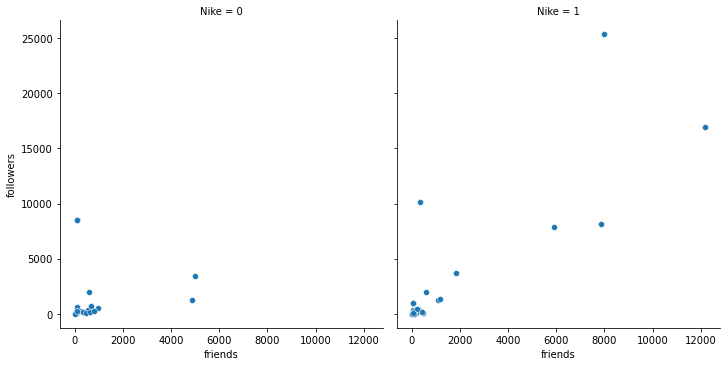

In [347]:
sns.relplot(
    data=NikevsAdidas, x="friends", y="followers",
    col="Nike", kind="scatter")